
# **Group Project**
## GRA 65602- Strategic Asset Allocation

This notebook contains the computations and models used to perform the analysis


In [9]:
## 
#  This cell cleans the environment whenever is needed
#  
rm(list = ls())

In [10]:
## 
#  This cell installs the library packages used
#  Uncomment if necessary
#
# install.packages(c("readxl", "ggplot2", "moments", "matlib", "zoo", "latex2exp"))

In [11]:
## 
#  This cell loads the libraries needed
#  @library readxl to read excel files
#  @library moments to compute statistics
#  @library zoo to compute correlations in rolling windows
#  @library latex2exp for formatting text in Latex
#  @library showtext to find fonts for plotting
#  @library systemfonts finds fonts for plotting
#  @module portConstruct with various portfolio construction methods
#
library(readxl)
library(moments)
library(zoo)
library(latex2exp)
library(showtext)
library(systemfonts)
source('portConstruct.R')

In [12]:
##
#  This cell loads and transforms the main data set
#  @dataset data.xlsx file containing the data
#  @return dataset expressed in decimals and formated date 
#
data                                      <- read_excel("data.xlsx", sheet = "csv")
data$Date                                 <- as.Date(data$Date, format = "%Y-%m-%d")
names(data)[names(data) == "Date"]        <- "date"
nonPercentage                             <- c("date", "P/D", "P/E")
data[, !(names(data) %in% nonPercentage)] <- data[, !(names(data) %in% nonPercentage)] / 100

[1] "-------------------------------------------QUESTION 2.1-------------------------------------------"

[1] "By solving for the funds relative risk aversion (two fund separation theorem), gamma is 2.371"

[1] "The descriptive statistics are (%)"

,equity,bonds
Mean,0.571,0.196
StDev,3.909,2.005
SR,0.146,0.098


[1] "Optimal weights, no rf and given infered risk aversion"

equity,bonds
1.225,-0.225


[1] "Descriptive statistics ptf with no rf and infered risk aversion"

,equity,bonds
w,1.225,-0.225
mu,0.007,0.007
sd,0.047,0.047
SR,0.141,0.141


[1] "-------------------------------------------QUESTION 2.2-------------------------------------------"

[1] "Optimal weights, tangency portfolio"

equity,bonds
0.567,0.433


[1] "Descriptive statistics, tangency portfolio"

,equity,bonds
w,0.567,0.433
mu,0.004,0.004
sd,0.026,0.026
SR,0.147,0.147


[1] "The optimal leverage is 2.339"

[1] "Optimal weights, with rf and infered risk aversion, weight in rf is  -1.339"

equity,bonds
1.327,1.012


[1] "Descriptive statistics ptf with rf and infered risk aversion"

,equity,bonds
w,1.327,1.012
mu,0.009,0.009
sd,0.062,0.062
SR,0.147,0.147


[1] "The certainty equivalent (CE) for the unconstrained ptf no rf asset is 1.004"

[1] "The certainty equivalent (CE) for the tangency ptf is 1.003"

[1] "The certainty equivalent (CE) for the unconstrained ptf with rf asset is 1.005"

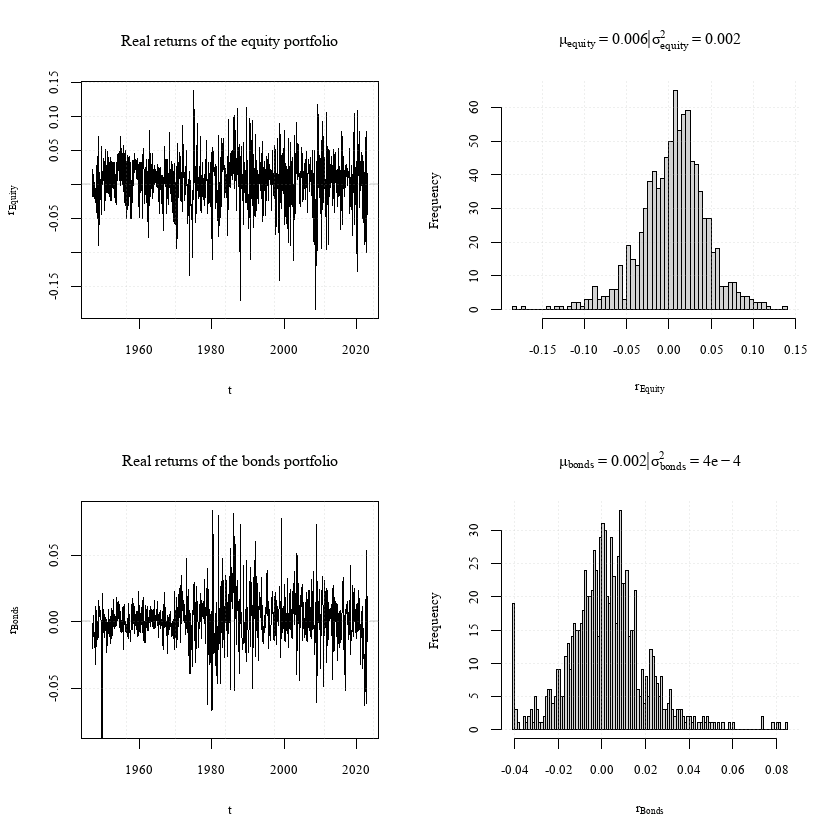

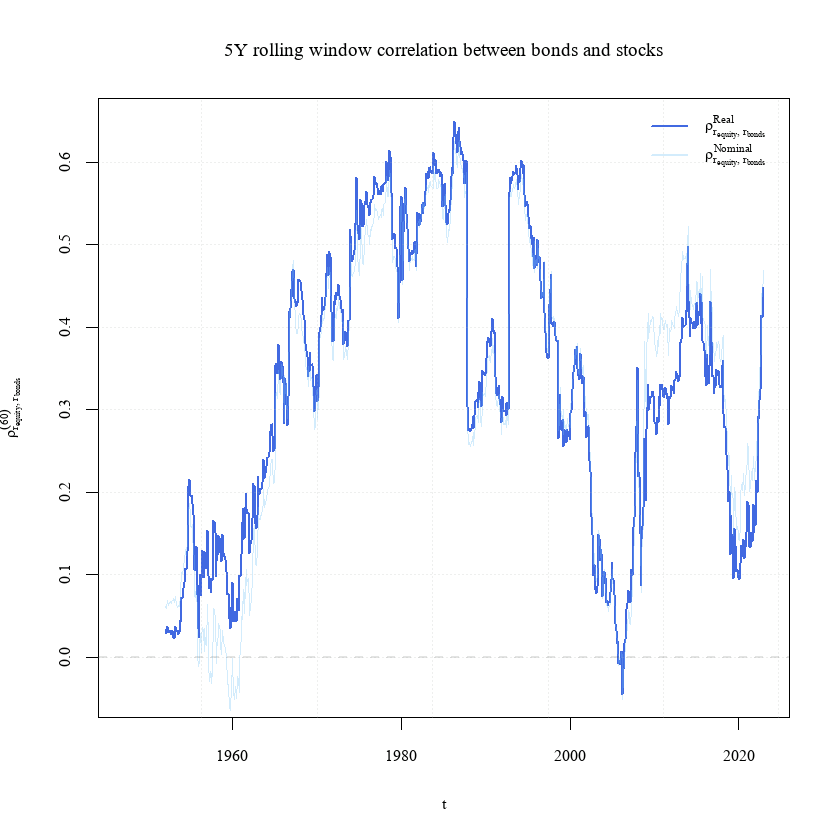

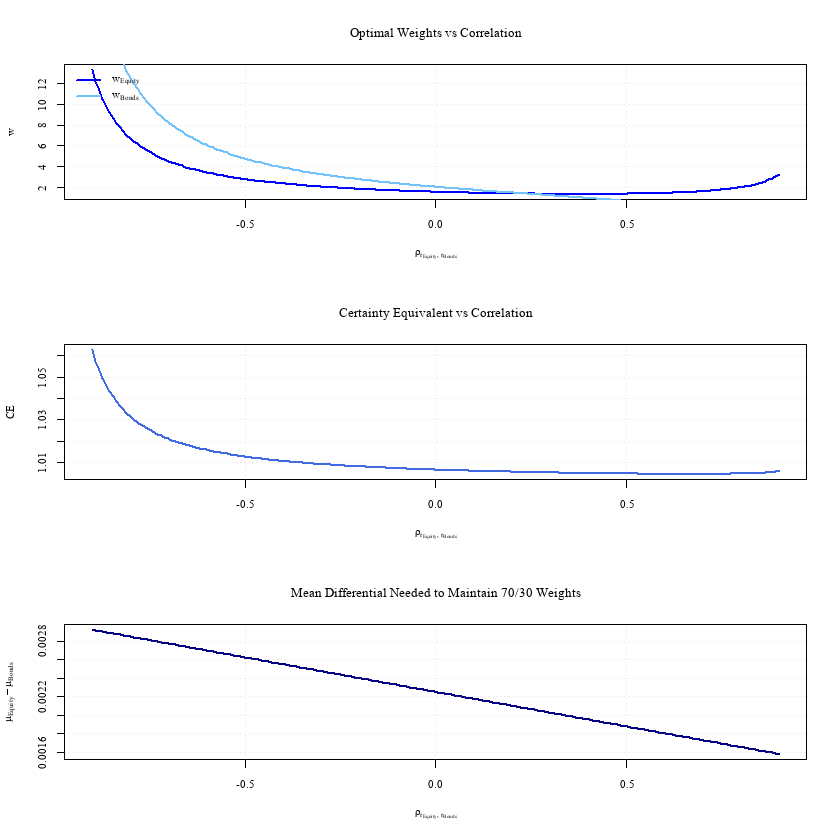

In [13]:
##
#  This cell solves question 2: Mean-variance analysis
#

tnr_path <- systemfonts::match_fonts("Times New Roman")$path
font_add("Times New Roman", regular = tnr_path)
showtext_auto()
par(family = "Times New Roman")


##
#  2.1
#

##
#  Gets the data needed to compute the benchmark portfolio
#  @param riskFree us_t1m US 1-month Treasury bill rate
#  @param inflation us_infl
#  @param equities wrld_eq world equity portfolio
#  @param bonds wrld_gbnd world government bonds portfolio
#  @return dataset used to compute the benchmark portfolio
#
selectColumns           <- c("date", "us_t1m", "us_infl", "wrld_eq", "wlrd_gbnd")
dataBenchmark           <- data[-1, selectColumns] 
colnames(dataBenchmark) <- c("date", "riskFree", "inflation", "equity", "bonds")

##
#  Get the mean, variance and correlation of equities and bonds
#  Use real returns = nominal returns - inflation
#  @param dataBenchmark
#
riskFree             <- dataBenchmark$riskFree
inflation            <- dataBenchmark$inflation
nominalReturnEquity  <- dataBenchmark$equity
nominalReturnBonds   <- dataBenchmark$bonds

# Computes real returns and moments of the 2 assets
realRiskFree           <- (1 + riskFree) / (1 + inflation) - 1
realReturnEquity       <- (1 + nominalReturnEquity) / (1 + inflation) - 1
realReturnBonds        <- (1 + nominalReturnBonds)  / (1 + inflation) - 1
meanEquity             <- mean(realReturnEquity)
varianceEquity         <- var(realReturnEquity)
meanBonds              <- mean(realReturnBonds)
varianceBonds          <- var(realReturnBonds)
covarianceEquityBonds  <- cov(realReturnEquity, realReturnBonds)

##
#  Infer the fund's relative risk aversion
#  Two fund separation theorem
#  gamma = (mu1 - m2) / (w1*(var1 + var2 + 2*cor(1,2)) - (var2 - cor(1,2)))
#  @param weightEquity 70% in benchmark
#  @param meanEquity
#  @param varianceEquity
#  @param meanBonds
#  @param varianceBonds
#  @param covarianceEquityBonds
#
weightEquity <- 0.70
gamma <- (
         (meanEquity - meanBonds) / 
         (weightEquity*(varianceEquity + varianceBonds + 2*covarianceEquityBonds) 
          - (varianceBonds - covarianceEquityBonds))
         )

paste("-------------------------------------------QUESTION 2.1-------------------------------------------")
paste("By solving for the funds relative risk aversion (two fund separation theorem), gamma is",round(gamma,3))

##         
#  Compute the unconstrained mean variance optimization given the risk aversion
#
# Computes the mean and covariance matrix
#
dataUnconstrainedRA           <- data.frame(cbind(realReturnEquity, realReturnBonds))
colnames(dataUnconstrainedRA) <- c("equity", "bonds")
meanReturns                   <- colMeans(dataUnconstrainedRA)
sigmaRaw                      <- cov(dataUnconstrainedRA)

# Displays the means and standard deviations of the assets (in percentages) as well as the Sharpe ratios (SR's)
desc <- cbind(100*meanReturns,100*sqrt(diag(sigmaRaw)),meanReturns/sqrt(diag(sigmaRaw)))
colnames(desc) <- c('Mean','StDev','SR')

paste("The descriptive statistics are (%)")
t(round(desc,3))

# Computes the optimal portfolio 
weightUncNoRf <- uncMeanVar_ra(meanReturns, sigmaRaw, gamma)

paste("Optimal weights, no rf and given infered risk aversion")
t(round(weightUncNoRf,3))

# Store results in a list
uncNoRfT <- list(w = weightUncNoRf, mu = c(weightUncNoRf %*% meanReturns), 
             sd = c(sqrt(weightUncNoRf %*% sigmaRaw %*% weightUncNoRf)),
             SR = c((weightUncNoRf %*% meanReturns)/(sqrt(weightUncNoRf %*% sigmaRaw %*% weightUncNoRf))))

paste("Descriptive statistics ptf with no rf and infered risk aversion")
t(round(as.data.frame(uncNoRfT), 3))

##
#  Plots the distributions for both equities and bonds
#  @param dataBenchmark
#
date <- dataBenchmark$date
par(mfrow = c(2,2))

# Plots the real returns of equity
t1         <- "Real returns of the equity portfolio"
t2         <- TeX(paste("$\\mu_{equity} = ", round(meanEquity, 3),
                "| \\sigma^2_{equity} = ", round(varianceEquity, 3),"$"
                  ))
x1         <- TeX("$t$")
y1         <- TeX("$r_{Equity}$")
x2         <- TeX("$r_{Equity}$")
colAbline  <- adjustcolor("black", alpha.f = 0.1)
plot(date, realReturnEquity, type = "l", main = t1, xlab = x1, ylab = y1, lwd = 1)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(realReturnEquity, breaks = 100, freq = T, main = t2, xlab = x2)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plots the real returns of bonds
t1 <- "Real returns of the bonds portfolio"
t2 <- TeX(paste("$\\mu_{bonds} = ", round(meanBonds, 3),
                "| \\sigma^2_{bonds} = ", round(varianceBonds, 4),"$"
         ))
x1 <- TeX("$t$")
y1 <- TeX("$r_{Bonds}$")
x2 <- TeX("$r_{Bonds}$")
# Truncates lowest 2% values to get a cleaner plot 
qL      <- quantile(realReturnBonds, 0.02)
returns <- realReturnBonds*(realReturnBonds > qL) + qL*(realReturnBonds <= qL)
plot(date, realReturnBonds, type = "l", main = t1, xlab = x1, ylab = y1,
     ylim = c(quantile(realReturnBonds, 0.001), max(realReturnBonds)), lwd = 1)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(returns, breaks = 100, freq = T, main = t2, xlab = x2)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

##
#  2.2
#

##
#  Analyzes optimal portfolio and the improvement in the certainty equivalent
#  if the fund were able to invest in the risk-free asset
#  @ param dataBenchmark 
#
excessReturnEquity <- realReturnEquity - realRiskFree
excessReturnBonds  <- realReturnBonds  - realRiskFree
       
# Get the tangency portfolio first
dataUnconstrainedRARf           <- data.frame(cbind(excessReturnEquity, excessReturnBonds))
colnames(dataUnconstrainedRARf) <- c("equity", "bonds")
meanExcess                      <- colMeans(dataUnconstrainedRARf)
sigmaExcess                     <- cov(dataUnconstrainedRARf)

# Solve for the tangency portfolio
weightTangency <- uncTangent(meanExcess, sigmaExcess)

paste("-------------------------------------------QUESTION 2.2-------------------------------------------")
paste("Optimal weights, tangency portfolio")
t(round(weightTangency, 3))

# Store results in a list
tangencyT <- list(w = weightTangency, mu = c(weightTangency %*% meanExcess), 
             sd = c(sqrt(weightTangency %*% sigmaExcess %*% weightTangency)),
             SR = c((weightTangency %*% meanExcess)/(sqrt(weightTangency %*% sigmaExcess %*% weightTangency))))

paste("Descriptive statistics, tangency portfolio")
t(round(as.data.frame(tangencyT), 3))

#  Compute the unconstrained mean variance optimization given the risk aversion
#  and risk free asset
sharpeRatioTagency <- tangencyT$SR
sigmaTangency      <- tangencyT$sd
optimalLeverage    <- sharpeRatioTagency / (gamma*sigmaTangency)

paste("The optimal leverage is", round(optimalLeverage, 3))

# Get weights
weightUncRf   <- optimalLeverage*weightTangency
weightRfUncRf <- 1 - optimalLeverage

paste("Optimal weights, with rf and infered risk aversion, weight in rf is ", round(weightRfUncRf, 3))
t(round(weightUncRf, 3))

# Store results in a list
meanRealRf <- mean(realRiskFree)
uncRfT <- list(w = weightUncRf, mu = c(weightUncRf %*% meanExcess + meanRealRf), # add rf return
             sd = c(sqrt(weightUncRf %*% sigmaExcess %*% weightUncRf)),
             SR = c((weightUncRf %*% meanExcess)/(sqrt(weightUncRf %*% sigmaExcess %*% weightUncRf))))

paste("Descriptive statistics ptf with rf and infered risk aversion")
t(round(as.data.frame(uncRfT), 3))

# Compare certainty equivalents
certaintyEquivalentNoRf     <- 1 + uncNoRfT$mu  - 0.5*gamma*(uncNoRfT$sd)^2
certaintyEquivalentTangency <- 1 + tangencyT$mu - 0.5*gamma*(tangencyT$sd)^2
certaintyEquivalentWithRf   <- 1 + uncRfT$mu    - 0.5*gamma*(uncRfT$sd)^2

paste("The certainty equivalent (CE) for the unconstrained ptf no rf asset is", round(certaintyEquivalentNoRf,3))
paste("The certainty equivalent (CE) for the tangency ptf is", round(certaintyEquivalentTangency,3))
paste("The certainty equivalent (CE) for the unconstrained ptf with rf asset is", round(certaintyEquivalentWithRf,3))

##
#  2.3
#

##
#  Compute and plot 5Y rolling window correlation of bonds and stocks
#  @param realReturnBonds
#  @param realReturnEquity
#  @return 60 months rolling window correlation and plot
#
window             <- 60
xReal              <- cbind(realReturnEquity, realReturnBonds)
rollWindowCorrReal <- rollapply(
                                xReal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
xNominal              <- cbind(nominalReturnEquity,nominalReturnBonds)
rollWindowCorrNominal <- rollapply(
                                xNominal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
par(mfrow = c(1,1))
colReal    <- adjustcolor("royalblue", alpha.f = 1.0)
colNominal <- adjustcolor("#73C2FB", alpha.f = 0.3)
t          <- "5Y rolling window correlation between bonds and stocks"
plot(date, rollWindowCorrReal, type = "l", col = colReal , lwd = 2, main = t,
    xlab = TeX("$t$"), ylab = TeX("$\\rho^{(60)}_{r_{equity},r_{bonds}}$"))
lines(date,rollWindowCorrNominal, col = colNominal)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
legend("topright",
       legend = c(TeX("$\\rho^{Real}_{r_{equity},r_{bonds}}$"), 
       TeX("$\\rho^{Nominal}_{r_{equity},r_{bonds}}$")),
       col = c(colReal, colNominal),
       lwd = 2,
       bg = "white",
       bty = "n")

### 
#  Effect of Correlation on:
#  1) Optimal Portfolio Weights
#  2) Certainty Equivalent (CE)
#  3) Required Mean Differential for Fixed Weights
#
# Variable Definitions
rhoGrid       <- seq(-0.9, 0.9, length.out = 200)  # range of correlations ρ
sigmaEquity   <- sd(realReturnEquity)               # volatility of equity
sigmaBonds    <- sd(realReturnBonds)                # volatility of bonds
muVec         <- meanReturns                        # mean returns (equity, bonds)
gammaRA       <- gamma                              # risk aversion γ from Q2.1
wFixed        <- c(0.70, 0.30)                      # target allocation for last task

# Covariance matrix Σ(ρ)
sigmaRho <- function(rho) {
  matrix(c(
    sigmaEquity^2,          rho * sigmaEquity * sigmaBonds,
    rho * sigmaEquity * sigmaBonds, sigmaBonds^2
  ), 2, 2)
}

# Optimal Portfolio Weights w*(ρ)
# w*(ρ) = (1/γ) Σ(ρ)^{-1} μ
wOpt <- t(sapply(rhoGrid, function(rho) {
  solve(sigmaRho(rho), muVec) / gammaRA
}))
colnames(wOpt) <- c("wEquity", "wBonds")

# Certainty Equivalent CE(ρ)
# CE = 1 + μ_p − 0.5 γ σ_p²
ceRho <- sapply(seq_along(rhoGrid), function(i) {
  w   <- wOpt[i,]
  Sig <- sigmaRho(rhoGrid[i])
  muP <- sum(w * muVec)
  sdP <- sqrt(as.numeric(t(w) %*% Sig %*% w))   
  1 + muP - 0.5 * gammaRA * sdP^2               
})

# Required Mean Differential (μ₁ − μ₂)
# to Maintain Fixed Weights (e.g., 70/30)
# μ(ρ) = γ Σ(ρ) w_fixed
muReq <- t(sapply(rhoGrid, function(rho) {
  gammaRA * sigmaRho(rho) %*% wFixed
}))

muDiff <- muReq[,1] - muReq[,2]

# Plots
par(mfrow = c(3,1))

# Optimal weights
plot(rhoGrid, wOpt[,1], type = "l", lwd = 2, col = "blue",
     ylab = TeX("$w$"), xlab = TeX("$\\rho_{r_{Equity},r_{Bonds}}$"),
     main = "Optimal Weights vs Correlation")
lines(rhoGrid, wOpt[,2], lwd = 2, col = "#73C2FB")
legend("topleft", legend = c(TeX("$w_{Equity}$"), TeX("$w_{Bonds}$")),
       col = c("blue", "#73C2FB"), lwd = 2, bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Certainty Equivalent
plot(rhoGrid, ceRho, type = "l", lwd = 2, col = "royalblue",
     ylab = TeX("$CE$"), xlab = TeX("$\\rho_{r_{Equity},r_{Bonds}}$"),
     main = "Certainty Equivalent vs Correlation")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Mean differential μ₁ − μ₂
plot(rhoGrid, muDiff, type = "l", lwd = 2, col = "navy",
     ylab = TeX("$\\mu_{Equity}-\\mu_{Bonds}$"), xlab = TeX("$\\rho_{r_{Equity},r_{Bonds}}$"),
     main = "Mean Differential Needed to Maintain 70/30 Weights")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

par(mfrow = c(1,1))